### Importing the Required Libraries

This step prepares the dataset for machine learning by splitting it into features (X) and target variable (y). It then divides the data into training and testing sets to evaluate the model's performance, ensuring a robust assessment of its predictive capabilities.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier

# Load the cleaned dataset
data = pd.read_csv('Downloads/water_potability_cleaned.csv')

data['Potability'] = data['Potability'].astype(int)

# Splitting features and target variable
X = data.drop('Potability', axis=1)
y = data['Potability']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Q-learning for Feature Adjustment

This step uses a Q-learning algorithm to adjust the training data, optimizing feature values based on a reward system. The Q-table guides modifications to feature values, potentially improving model performance by making strategic adjustments to the training data.

Q-Table after training:
[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.1 0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.1 0.  ... 0.  0.  0. ]]


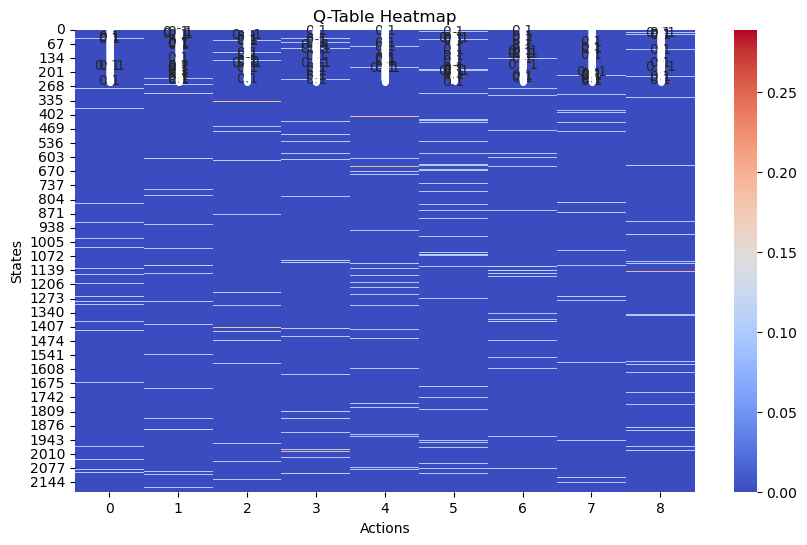

In [3]:
# Define the environment and Q-learning parameters
states = X_train.shape[0]
actions = X_train.shape[1]
q_table = np.zeros((states, actions))
learning_rate = 0.1
discount_factor = 0.9
episodes = 1000

# Q-learning algorithm
for episode in range(episodes):
    state = np.random.randint(0, states)
    action = np.random.choice(actions)
    old_value = q_table[state, action]
    next_state = np.random.randint(0, states)
    
    # Temporary model to calculate reward
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    reward = accuracy_score(y_train, y_pred)
    
    next_max = np.max(q_table[next_state])
    new_value = (1 - learning_rate) * old_value + learning_rate * (reward + discount_factor * next_max)
    q_table[state, action] = new_value

# Print the Q-table after training
print("Q-Table after training:")
print(q_table)

# Visualize the Q-table
plt.figure(figsize=(10, 6))
sns.heatmap(q_table, annot=True, cmap='coolwarm', cbar=True)
plt.title('Q-Table Heatmap')
plt.xlabel('Actions')
plt.ylabel('States')
plt.show()

# Adjust training data based on Q-table
X_train_adjusted = X_train.copy()
for state in range(states):
    best_action = np.argmax(q_table[state])
    X_train_adjusted.iloc[state, best_action] += np.random.normal(0, 0.1)


### Hyperparameter Tuning and Model Evaluation for Decision Tree after Q-Learning

This step performs hyperparameter tuning on a Decision Tree model using the adjusted training data from the Q-learning process. It evaluates the optimized model's performance and visualizes feature importance, providing insights into the effects of the Q-learning adjustments on model accuracy and feature contributions.

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
Q-Learning Accuracy: 0.6357827476038339
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.85      0.74       583
           1       0.54      0.28      0.37       356

    accuracy                           0.64       939
   macro avg       0.60      0.57      0.56       939
weighted avg       0.61      0.64      0.60       939



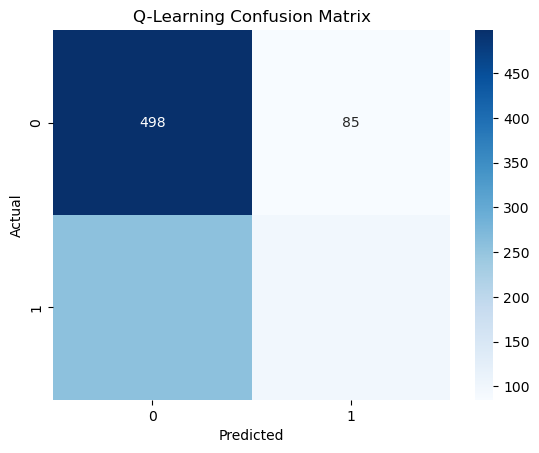

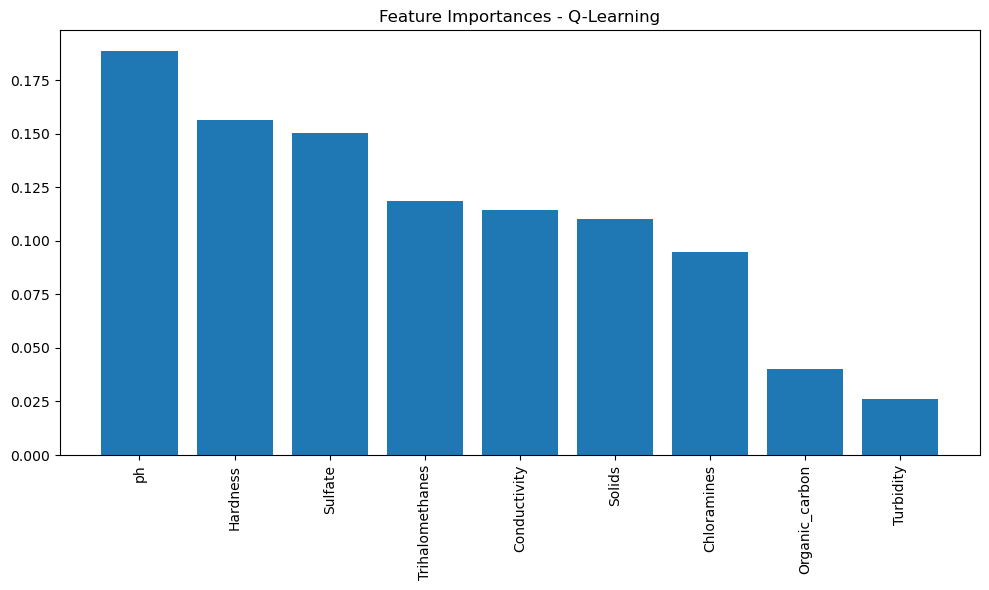

In [6]:
# Hyperparameter tuning for Decision Tree
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform hyperparameter tuning on the adjusted training data
model = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_adjusted, y_train)

# Best parameters
print(f"Best parameters: {grid_search.best_params_}")

# Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train_adjusted, y_train)

# Predict and evaluate
y_pred_test = best_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Q-Learning Accuracy: {accuracy_test}")
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Q-Learning Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances - Q-Learning")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()